## Data Analysis using BulkLMM - BXD Longevity Study

In [1]:
using CSV, DelimitedFiles, DataFrames, Missings, XLSX
using LinearAlgebra, Statistics, Optim
using Random, Distributions, LoopVectorization
using GeneNetworkAPI, Downloads
using BenchmarkTools

In [2]:
using Plots

In [3]:
local_path = "../../BulkLMM.jl/src";

In [4]:
import LossFunctions: HuberLoss, value
import Distributions: Chisq,ccdf
import StatsBase: mad, sample

function huberize(y::Vector{Float64})
    m = median(y)
    s = mad(y,normalize=true)
    z = (y.-m)./s
    l = value.(HuberLoss(1),z)
    x = sign.(z).* sqrt.(2*l)
    return m .+ s.*x
end

huberize (generic function with 1 method)

## Load processed_data:

### By individuals:

In [5]:
BXD_pheno_ind_summary_df = CSV.read("data/GN886_pheno_summary.csv", DataFrame);

By individuals, there are 248 individual samples for 32445 livear proteome.

In [6]:
println(size(BXD_pheno_ind_summary_df)) 
BXD_pheno_ind_summary_df[1:10, 1:10]

(248, 32448)


Row,Sample,Strain,Strain_num,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H1009,BXD9,9,11.349,11.534,17.587,17.517,17.309,16.574,16.323
2,H0370,BXD9,9,11.249,12.735,17.427,17.325,17.252,16.685,16.021
3,H2577,BXD9,9,12.415,10.487,17.89,17.488,17.594,16.731,16.208
4,H0365,BXD9,9,11.374,10.674,17.714,17.401,17.381,16.621,16.337
5,H1333,BXD13,13,11.687,11.524,17.362,17.367,17.071,16.465,15.97
6,H2259,BXD24,24,11.837,11.715,17.57,17.792,17.505,16.894,16.277
7,H1792,BXD24,24,11.563,11.434,17.789,17.847,17.416,17.042,16.292
8,H1791,BXD24,24,12.5,12.273,17.944,17.833,17.63,16.862,16.3
9,H1541,BXD24,24,11.815,11.564,17.794,17.759,17.456,16.878,16.377


In [7]:
names(BXD_pheno_ind_summary_df)[7515]

"P61924_VALRGEDVPLTEQTVSQVLQSAK_3"

In [8]:
BXD_geno_ind_summary_df = CSV.read("data/GN886_geno_summary.csv", DataFrame);

By individuals, there are 248 individual samples for 7321 markers.

In [9]:
println(size(BXD_geno_ind_summary_df)) 
BXD_geno_ind_summary_df[1:10, 1:10]

(248, 7324)


Row,Sample,Strain,Strain_num,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H1009,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,H0370,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,H2577,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,H0365,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,H1333,BXD13,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,H2259,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,H1792,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,H1791,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,H1541,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### By strains:

In [10]:
BXD_pheno_strains_summary_df = CSV.read("data/GN886_pheno_strain_means_summary.csv", DataFrame);

By strains, there are 50 BXD strains for 32445 liver proteome.

In [11]:
println(size(BXD_pheno_strains_summary_df)) 
BXD_pheno_strains_summary_df[1:10, 1:10]

(50, 32447)


Row,Strain,Number of Samples,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2,Q99M02_QLQQVGTVSK_2
,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,BXD9,4,11.5968,11.3575,17.6545,17.4327,17.384,16.6528,16.2222,16.3227
2,BXD13,1,11.687,11.524,17.362,17.367,17.071,16.465,15.97,15.98
3,BXD24,5,12.0778,11.7458,17.7926,17.8152,17.5168,16.9196,16.3012,16.4304
4,BXD27,3,11.717,11.149,17.336,17.3143,17.165,16.5283,15.9407,16.002
5,BXD29,11,11.735,11.3496,17.4583,17.3877,17.2431,16.4945,16.0869,16.1075
6,BXD32,8,11.6266,11.554,17.8254,17.7716,17.4639,16.9029,16.434,16.425
7,BXD34,13,11.7491,11.9135,17.6108,17.5974,17.2988,16.7761,16.3147,16.2926
8,BXD39,5,11.9158,11.719,17.395,17.385,17.157,16.5226,16.179,16.0594
9,BXD40,8,11.8651,11.6817,17.5986,17.6386,17.3861,16.6824,16.2855,16.2523


In [12]:
BXD_geno_strains_summary_df = CSV.read("data/GN886_geno_strains_summary.csv", DataFrame);

By strains, there are 50 BXD strains for 7321 markers.

In [13]:
println(size(BXD_geno_strains_summary_df)) 
BXD_geno_strains_summary_df[1:10, 1:10]

(50, 7322)


Row,Strain,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298,rs51852623,rs31879829
,String7,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,BXD9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BXD13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BXD24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BXD27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,BXD29,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,BXD32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,BXD34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,BXD39,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,BXD40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Load functions:

In [14]:
include(joinpath(local_path, "kinship.jl"));
include(joinpath(local_path, "util.jl"));
include(joinpath(local_path, "wls.jl"));
include(joinpath(local_path, "lmm.jl"));
include(joinpath(local_path, "gridbrent.jl"));
include(joinpath(local_path, "transform_helpers.jl"));
include(joinpath(local_path, "scan.jl"));
include(joinpath(local_path, "bulkscan_helpers.jl"));
include(joinpath(local_path, "bulkscan.jl"));
include(joinpath(local_path, "readData.jl"));

## Objectives

- gemma one trait, ind and strains

- scan_alt one trait, ind and strains

- scan_null one trait, ind and strains

- bulkscan_grid (null), all traits, ...

- data structure for all traits results...

- Heatmap grids_taken, compare on strain means and individuals

- Histogram of heritabilities (null) for all traits (both strain means and individual level data)

- Loglikelihood by h2_grid plot, strain means v.s. individuals

- Report fixed effects:

- Adjusting difference in the number of samples across strains

- Histogram of heritabilities (null) for all traits (both strain means and individual level data)

## Run BulkLMM.jl:

### Calculate kinship:

First, calculate the kinship matrix of relatedness among the strains (50-by-50):

In [15]:
geno_strains = Matrix{Float64}(BXD_geno_strains_summary_df[:, 2:end]);

In [16]:
kinship_strains = calcKinship(geno_strains);

Then, construct the kinship matrix of relatedness among the individuals based on which strain they are from:

In [17]:
function calcRepeats(x::Array{Int64, 1})
    
    counting_dict = Dict{Int64, Int64}();
    
    for i in 1:length(x)
        curr_key = x[i];
        if haskey(counting_dict, curr_key) # if current key already exists
            counting_dict[curr_key] += 1;
        else # if current key does not present, add it as a new key
            counting_dict[curr_key] = 1;
        end
    end
    
    return counting_dict
    
end

calcRepeats (generic function with 1 method)

In [18]:
function calcIndKinship_from_StrainKinship(kinship_strains::Array{Float64, 2}, 
                                           strain_info_about_samples::Array{Int64, 1})
    
    counting_dict = calcRepeats(strain_info_about_samples);
    reps_each_strain = map(x -> counting_dict[x], unique(strain_info_about_samples));
    
    # Initialize the placeholder:
    kinship_ind_from_strains = ones(sum(reps_each_strain), sum(reps_each_strain));

    # process the first BXD strain...
    reps_strain_1 = reps_each_strain[1];
    k_11 = kinship_strains[1, 1];
    # block_11 = ones(reps_strain_1, reps_strain_1);

    row_id = 0;
    col_id = 0;

    @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                             (row_id+1):(row_id+reps_strain_1)] .*= k_11;

    for j in 2:length(reps_each_strain)
        reps_strain_j = reps_each_strain[j];
        k_1j = kinship_strains[1, j];
        # block_1j = ones(reps_strain_1, reps_strain_j);

        col_id += reps_each_strain[j-1];
        @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                                 (col_id+1):(col_id+reps_strain_j)] .*= k_1j;

        # process the off-diagonal block conveniently...
        # block_j1 = ones(reps_strain_j, reps_strain_1);
        kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                 (row_id+1):(row_id+reps_strain_1)] .*= k_1j;

    end

    # process for the second BXD strain and all after...
    # for i in 2:length(reps_each_strain)
    for i in 2:length(reps_each_strain)

        reps_strain_i = reps_each_strain[i];
        k_ii = kinship_strains[i, i];
        # block_ii = ones(reps_strain_i, reps_strain_i);

        row_id += reps_each_strain[i-1];
        @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                 (row_id+1):(row_id+reps_strain_i)] .*= k_ii;

        col_id = row_id+reps_strain_i;

        for j in (i+1):length(reps_each_strain)

            reps_strain_j = reps_each_strain[j];
            k_ij = kinship_strains[i, j];
            # block_ij = ones(reps_strain_i, reps_strain_j);

            @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                     (col_id+1):(col_id+reps_strain_j)] .*= k_ij;

            # process the off-diagonal block conveniently...
            # block_ji = ones(reps_strain_j, reps_strain_i);
            @views kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                     (row_id+1):(row_id+reps_strain_i)] .*= k_ij;

            col_id += reps_each_strain[j];
        end
    
    end
    
    return kinship_ind_from_strains
end

calcIndKinship_from_StrainKinship (generic function with 1 method)

In [19]:
BXD_geno_ind_summary_df.Strain_num = Vector{Int64}(BXD_geno_ind_summary_df.Strain_num);

In [20]:
@time kinship_ind_from_strains = calcIndKinship_from_StrainKinship(kinship_strains, BXD_geno_ind_summary_df.Strain_num);

  0.000266 seconds (76 allocations: 503.766 KiB)


Compare the runtime with directly calculating the kinship matrix from individual genotype data:

In [21]:
geno_ind = Matrix{Float64}(BXD_geno_ind_summary_df[:, 4:end]);

In [24]:
@time kinship_ind_from_ind = calcKinship(geno_ind);

  6.994644 seconds (306.28 k allocations: 8.368 GiB, 18.28% gc time)


In [25]:
maximum(abs.(kinship_ind_from_ind .- kinship_ind_from_strains))

0.04186586531894554

### Single-trait genome scans:

To see single trait genome scan results, we take the 29437-th livear proteomic as the single trait to run analysis:  

In [22]:
lp_names = names(BXD_pheno_ind_summary_df)[4:end];

In [23]:
lp_id = 29437;
lp_names[lp_id]

"Q9Z2I8_SSGLPITSAVDLEDAAK_3"

In [123]:
prior = [1.0, 0.1];

#### For individual liver proteome

In [24]:
lp_ind_Y = Matrix{Float64}(BXD_pheno_ind_summary_df[:, 4:end]);
lp_ind_y = reshape(lp_ind_Y[:, lp_id], :, 1);

In [25]:
lpst_ind_Y = colStandardize(lp_ind_Y);
lpst_ind_y = reshape(lpst_ind_Y[:, lp_id], :, 1);

In [132]:
@time scan_results_ind = scan(lpst_ind_y, geno_ind, kinship_ind_from_strains; 
                              prior_variance = prior[1], prior_sample_size = prior[2]);

  0.238206 seconds (82.18 k allocations: 136.225 MiB, 38.68% gc time)


In [134]:
BLAS.set_num_threads(Threads.nthreads())

In [135]:
BLAS.get_num_threads()

8

In [136]:
@time scan_results_ind_alt = scan(lpst_ind_y, geno_ind, kinship_ind_from_strains;
                                  assumption = "alt", 
                                  prior_variance = prior[1], prior_sample_size = prior[2]);

 13.690174 seconds (11.70 M allocations: 14.362 GiB, 13.68% gc time)


In [138]:
@time scan_perms_results_ind = scan(lpst_ind_y, geno_ind, kinship_ind_from_strains;
                                    prior_variance = prior[1], prior_sample_size = prior[2],
                                    permutation_test = true, nperms = 1000, original = true);

  0.130233 seconds (154.98 k allocations: 165.914 MiB, 17.08% gc time, 18.44% compilation time)


In [155]:
single_results_ind = DataFrame(hcat(scan_results_ind.lod, scan_results_ind_alt.lod, scan_perms_results_ind[:, 1]), ["scan_null", "scan_alt", "scan_perms.original"]);

#### For liver proteome means by strains

In [120]:
lp_strains_Y = Matrix{Float64}(BXD_pheno_strains_summary_df[:, 3:end]);
lp_strains_y = reshape(lp_strains_Y[:, lp_id], :, 1);

In [121]:
lpst_strains_Y = colStandardize(lp_strains_Y);
lpst_strains_y = reshape(lpst_strains_Y[:, lp_id], :, 1);

In [152]:
@time scan_results_strains = scan(lpst_strains_y, geno_strains, kinship_strains; 
                                  prior_variance = prior[1], prior_sample_size = prior[2]);

  0.059330 seconds (81.02 k allocations: 32.316 MiB, 25.51% gc time)


In [153]:
@time scan_results_strains_alt = scan(lpst_strains_y, geno_strains, kinship_strains;
                                      assumption = "alt",
                                      prior_variance = prior[1], prior_sample_size = prior[2]);

  1.163256 seconds (4.09 M allocations: 1.234 GiB, 11.63% gc time)


In [154]:
@time scan_perms_results_strains = scan(lpst_strains_y, geno_strains, kinship_strains;
                                        permutation_test = true, nperms = 1000, original = true, 
                                        prior_variance = prior[1], prior_sample_size = prior[2]);

  0.040732 seconds (90.12 k allocations: 78.703 MiB, 25.83% gc time)


In [158]:
single_results_strains = DataFrame(hcat(scan_results_strains.lod, scan_results_strains_alt.lod, scan_perms_results_strains[:, 1]), ["scan_null", "scan_alt", "scan_perms.original"]);

### Multiple-trait genome scans:

In [159]:
BLAS.set_num_threads(Threads.nthreads())

In [175]:
BLAS.get_num_threads()

1

In [176]:
grid_list = collect(0.0:0.01:0.99);

#### For individual liver proteome

In [177]:
@time bulkscan_results_ind_null = bulkscan_null(lpst_ind_Y, geno_ind, kinship_ind_from_strains; nb = Threads.nthreads(),
                                                prior_variance = 1.0, prior_sample_size = 0.1);

250.398725 seconds (2.60 G allocations: 1.813 TiB, 32.76% gc time)


In [178]:
BLAS.set_num_threads(Threads.nthreads())

In [179]:
@time bulkscan_results_ind_alt_grid = bulkscan_alt_grid(lpst_ind_Y, geno_ind, kinship_ind_from_strains, grid_list);

161.455038 seconds (43.45 M allocations: 208.841 GiB, 21.27% gc time)


In [180]:
@time bulkscan_results_ind_null_grid = bulkscan_null_grid(lpst_ind_Y, geno_ind, kinship_ind_from_strains, grid_list);

 54.243898 seconds (46.80 M allocations: 41.761 GiB, 71.22% gc time)


#### For liver proteome means by strains

In [181]:
@time bulkscan_results_strains_null = bulkscan_null(lpst_strains_Y, geno_strains, kinship_strains; nb = Threads.nthreads(),
                                                    prior_variance = 1.0, prior_sample_size = 0.1);

 59.240212 seconds (2.61 G allocations: 434.448 GiB, 22.91% gc time)


In [182]:
BLAS.set_num_threads(Threads.nthreads())

In [183]:
@time bulkscan_results_strains_alt_grid = bulkscan_alt_grid(lpst_strains_Y, geno_strains, kinship_strains, grid_list);

 74.517620 seconds (43.45 M allocations: 184.223 GiB, 2.77% gc time)


In [184]:
@time bulkscan_results_strains_null_grid = bulkscan_null_grid(lpst_strains_Y, geno_strains, kinship_strains, grid_list);

  8.604367 seconds (43.67 M allocations: 11.782 GiB, 34.00% gc time)


## Examine loglikelihood:

In [168]:
## Inputs: Original data, a given h2 to evaluate loglik on
##         (optional) prior for regularization loglik near the upper boundary pt.
## Outputs: the logliks (null, alt mean model) under the given h2
function getLL(y::Array{Float64, 2}, G::Array{Float64, 2}, K::Array{Float64, 2}, markerID::Int64, h2::Float64; prior::Array{Float64, 1} = [0.0, 0.0])
    
    Gj = reshape(G[:, markerID], :, 1);
    (y0, X0, lambda0) = transform_rotation(y, Gj, K; addIntercept = true);
    w = makeweights(h2, lambda0);
    X0_inter = reshape(X0[:, 1], :, 1);
    
    return (ll_null = wls(y0, X0_inter, w, prior).ell, ll_markerID = wls(y0, X0, w, prior).ell)
end

getLL (generic function with 1 method)

In [169]:
@time opt = optimize(x -> -getLL(lpst_strains_y, geno_strains, kinship_strains, 1997, x).ll_null, 0.0, 1.0)

  0.109692 seconds (159.36 k allocations: 12.109 MiB, 78.27% compilation time)


Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000000, 1.000000]
 * Minimizer: 1.000000e+00
 * Minimum: 2.433404e+01
 * Iterations: 36
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 37

In [170]:
@time gridopt = gridbrent(x -> -getLL(lpst_strains_y, geno_strains, kinship_strains, 1997, x).ll_null, 0.0, 1.0, 10);

  0.370448 seconds (346.71 k allocations: 51.001 MiB, 3.23% gc time, 32.76% compilation time)


In [172]:
@time ml_null = scan(lpst_strains_y, geno_strains, kinship_strains; 
                     prior_variance = prior[1], prior_sample_size = prior[2]);

  0.043311 seconds (81.02 k allocations: 32.316 MiB, 26.43% gc time)


In [171]:
@time reml_null = scan(lpst_strains_y, geno_strains, kinship_strains; 
                       reml = true, 
                       prior_variance = prior[1], prior_sample_size = prior[2]);

  0.053871 seconds (81.39 k allocations: 32.420 MiB, 23.21% gc time)


In [173]:
@time ml_alt = scan(lpst_strains_y, geno_strains, kinship_strains; 
                    reml = false, assumption = "alt", 
                    prior_variance = prior[1], prior_sample_size = prior[2]);

  1.164888 seconds (4.15 M allocations: 1.238 GiB, 11.88% gc time, 2.01% compilation time)


In [ ]:
@time reml_alt = scan(lpst_strains_y, geno_strains, kinship_strains; 
                      reml = true, assumption = "alt",
                      prior_variance = prior[1], prior_sample_size = prior[2]);

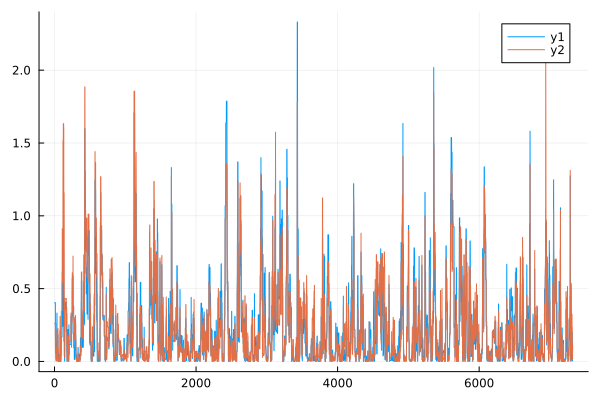

In [65]:
plot(reml_null.lod)
plot!(reml_alt.lod)

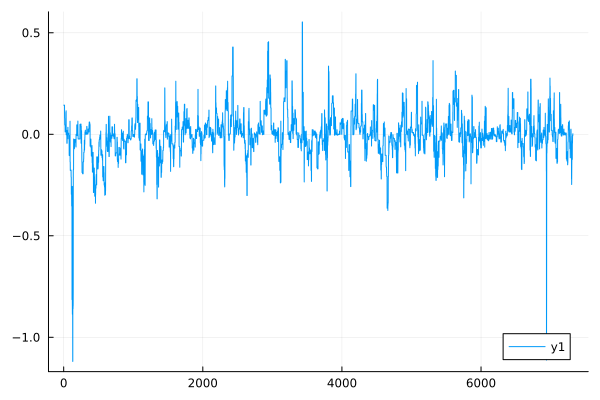

In [66]:
plot(reml_null.lod .- reml_alt.lod)

In [67]:
opt.minimizer

0.999999984947842

In [68]:
opt.minimum

-94.94004101338442

In [69]:
-getLL(lp_strains_y_hub, geno_strains, kinship_strains, 1997, 0.0).ll_null

-94.94188585056145

In [70]:
opt.minimum <= -getLL(lp_strains_y_hub, geno_strains, kinship_strains, 1997, 0.0).ll_null

false

In [71]:
gridopt

(minimum = -94.94188585056143, minimizer = 1.577501388940428e-15)

In [109]:
prior = [1.0, 0.1];

In [111]:
ind_ll = map(x -> getLL(lpst_ind_y, geno_ind, kinship_ind_from_strains, 1997, x; prior = prior), collect(0.0:0.001:0.999));
strains_ll = map(x -> getLL(lpst_strains_y, geno_strains, kinship_strains, 1997, x; prior = prior), collect(0.0:0.001:0.999));

ind_ell_list = zeros(999);
strains_ell_list = zeros(999);
strains_ell_list_alt = zeros(999);
for k in 1:999 
    ind_ell_list[k] = ind_ll[k].ll_null;
    strains_ell_list[k] = strains_ll[k].ll_null;
    strains_ell_list_alt[k] = strains_ll[k].ll_markerID;
end

In [112]:
getLL(lp_strains_y_hub, geno_strains, kinship_strains, 1997, 0.6011922559652536)

(ll_null = 94.12493340134026, ll_markerID = 94.3458108345969)

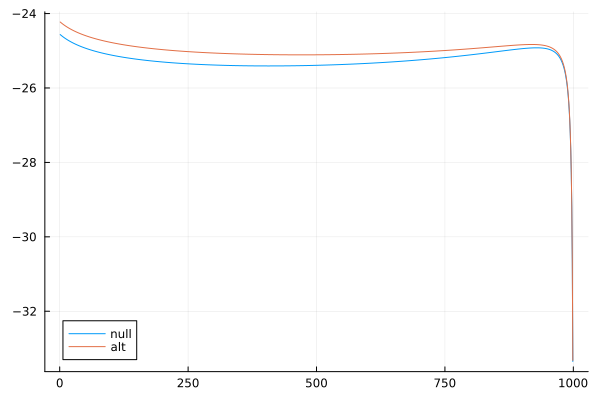

In [113]:
plot(strains_ell_list, label = "null")
scatter!()
plot!(strains_ell_list_alt, label = "alt")

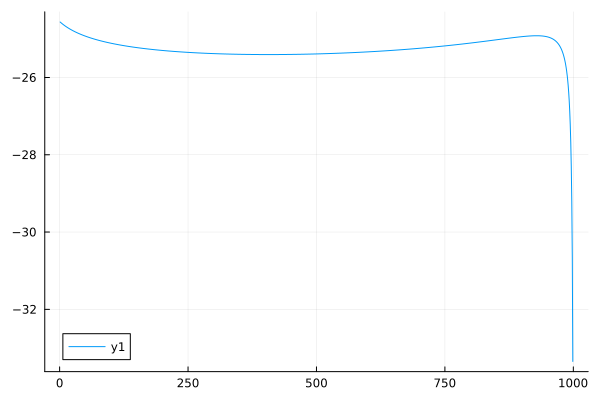

In [114]:
plot(strains_ell_list) # covariates+marker

In [115]:
findmax(strains_ell_list)

(-24.564386855330927, 1)

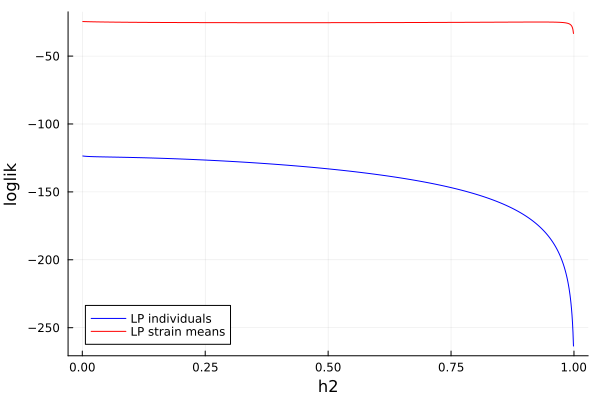

In [116]:
plot(collect(1:999).*0.001, ind_ell_list, xlabel = "h2", ylabel = "loglik", label = "LP individuals", color = "blue", legend=:bottomleft)
plot!(collect(1:999).*0.001, strains_ell_list, xlabel = "h2", ylabel = "loglik", label = "LP strain means", color = "red")

## Examine hsqs, maxLods:

In [187]:
function getMaxLODs(L::Array{Float64, 2})
    
    m = size(L, 2);
    max_marker = Array{Int64, 1}(undef, m);
    max_lod = Array{Float64, 1}(undef, m);
    
    for i in 1:m
        result_i = findmax(L[:, i]); 
        max_marker[i] = result_i[2];
        max_lod[i] = result_i[1];
    end
    
    return (max_markers = max_marker, max_lod = max_lod);
end

getMaxLODs (generic function with 1 method)

In [188]:
@time begin
    max_results_ind = getMaxLODs(L_ind);
    max_results_strains = getMaxLODs(L_strains);
end;

  3.271679 seconds (129.79 k allocations: 3.547 GiB, 16.02% gc time)


In [189]:
@time bulkscan_results_ind_null_4 = bulkscan_null(lpst_ind_Y, geno_ind, kinship_ind_from_strains; nb = Threads.nthreads(),
                                                  prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

247.608813 seconds (2.67 G allocations: 1.887 TiB, 27.92% gc time)


In [ ]:
@time bulkscan_results_null_strains_4 = bulkscan_null(lpst_strains_Y, geno_strains, kinship_strains; nb = Threads.nthreads(),
                                                      prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

In [185]:
L_ind = bulkscan_results_ind_null.L;
L_strains = bulkscan_results_strains_null.L;
h2s_ind = bulkscan_results_ind_null.h2_null_list;
h2s_strains = bulkscan_results_strains_null.h2_null_list;

In [186]:
L_ind_4 = bulkscan_results_ind_null_4.L;
L_strains_4 = bulkscan_results_null_strains_4.L;
h2s_ind_4 = bulkscan_results_ind_null_4.h2_null_list;
h2s_strains_4 = bulkscan_results_null_strains_4.h2_null_list;

LoadError: UndefVarError: bulkscan_results_ind_null_4 not defined

### Heritabilities:

In [87]:
findall(abs.(h2s_strains .- h2s_strains_4) .>= 0.5)

1947-element Vector{Int64}:
     6
    13
    33
    38
    41
    47
    53
    55
    59
    63
    65
    68
    71
     ⋮
 32228
 32250
 32270
 32278
 32334
 32339
 32348
 32355
 32364
 32379
 32424
 32441

In [88]:
findmax(abs.(h2s_strains .- h2s_strains_4))

(0.9140937721238206, 22797)

In [89]:
largest_h2diff_strains_y = reshape(lpst_strains_Y[:, 6], :, 1);

In [90]:
@time test_scan_results_opt1 = scan(largest_h2diff_strains_y, geno_strains, kinship_strains; 
                             prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 1);

  0.063540 seconds (81.10 k allocations: 32.339 MiB, 34.31% gc time)


In [91]:
@time test_scan_results_opt2 = scan(largest_h2diff_strains_y, geno_strains, kinship_strains; 
                             prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 2);

  0.050571 seconds (82.47 k allocations: 32.713 MiB, 25.12% gc time)


In [92]:
@time test_scan_results_opt4 = scan(largest_h2diff_strains_y, geno_strains, kinship_strains; 
                             prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

  0.042157 seconds (83.84 k allocations: 33.088 MiB, 23.63% gc time)


In [93]:
@time test_scan_results_opt10 = scan(largest_h2diff_strains_y, geno_strains, kinship_strains; 
                             prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 10);

  0.032458 seconds (87.97 k allocations: 34.216 MiB)


In [94]:
test_scan_results_opt1.h2_null

0.6582586920663421

In [95]:
test_scan_results_opt2.h2_null

7.258511121435776e-16

In [96]:
test_scan_results_opt4.h2_null

7.281068220985078e-16

In [97]:
test_scan_results_opt10.h2_null

7.556752351802334e-16

In [98]:
getLL(largest_h2diff_strains_y, geno_strains, kinship_strains, 1, 0.0)

(ll_null = -24.49493231706208, ll_markerID = -24.331720041707165)

In [99]:
getLL(largest_h2diff_strains_y, geno_strains, kinship_strains, 1, 0.66)

(ll_null = -24.962051098420524, ll_markerID = -24.678442130923703)

In [100]:
# ind_ll = map(x -> getLL(largest_h2diff_strains_y, geno_strains, kinship_strains, 1, x), collect(0.0:0.001:0.999));
l_strains_ll = map(x -> getLL(largest_h2diff_strains_y, geno_strains, kinship_strains, 1, x;
                              prior = [1.0, 0.1]), 
                   collect(0.0:0.001:0.999));

# ind_ell_list = zeros(999);
l_strains_ell_list = zeros(999);
l_strains_ell_list_alt = zeros(999);
for k in 1:999 
    # ind_ell_list[k] = ind_ll[k].ll_null;
    l_strains_ell_list[k] = l_strains_ll[k].ll_null;
    l_strains_ell_list_alt[k] = l_strains_ll[k].ll_markerID;
end

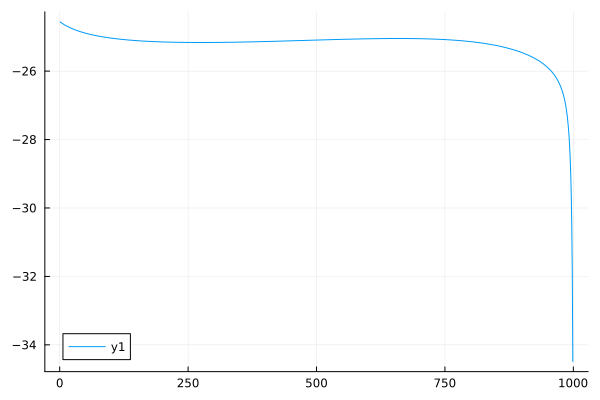

In [101]:
plot(l_strains_ell_list)

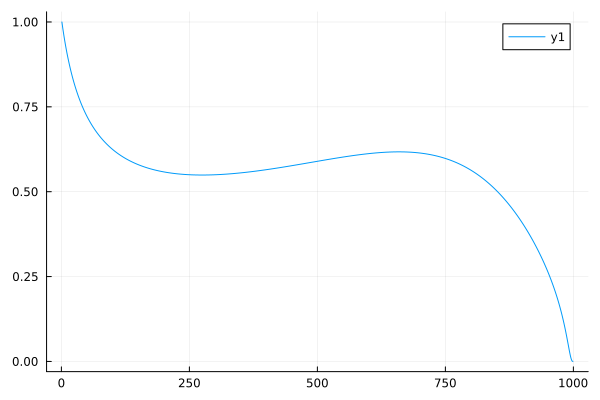

In [108]:
plot(exp.(l_strains_ell_list .- maximum(l_strains_ell_list)))

In [ ]:
plot(exp.(l_strains_ell_list .- maximum(l_strains_ell_list)))

### Maximum lod scores:

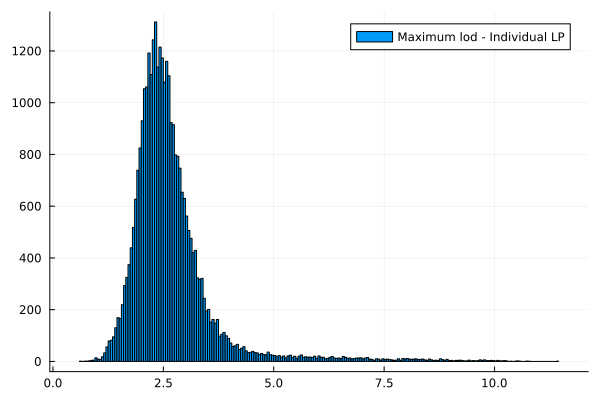

In [102]:
histogram(max_results_ind.max_lod, label = "Maximum lod - Individual LP")

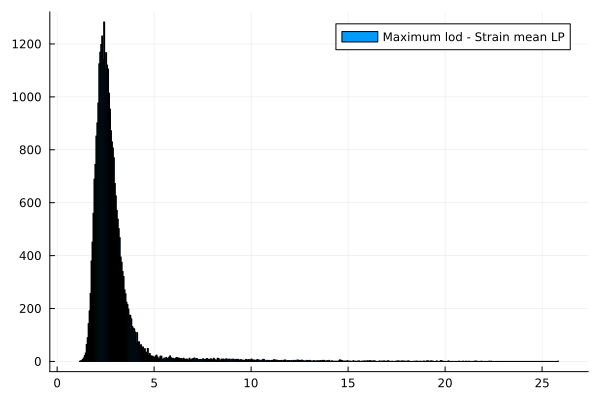

In [103]:
histogram(max_results_strains.max_lod, label = "Maximum lod - Strain mean LP")

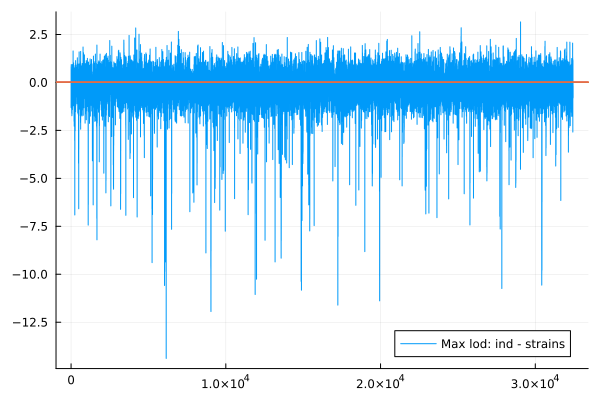

In [104]:
plot(max_results_ind.max_lod .- max_results_strains.max_lod, label = "Max lod: ind - strains")
hline!(x -> x = 0.0, label = "")

In [105]:
mean(max_results_ind.max_lod .- max_results_strains.max_lod .>= 0.0)

0.40634920634920635

## Run GEMMA for single-trait scans:

In [53]:
pwd()

"/home/zyu20/git/BulkLMM_Analyses/BXDLongevity"

In [67]:
gemma = "/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64"

"/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64"

In [68]:
run(`$gemma -h`)

GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021

 type ./gemma -h [num] for detailed help
 options: 
  1: quick guide
  2: file I/O related
  3: SNP QC
  4: calculate relatedness matrix
  5: perform eigen decomposition
  6: perform variance component estimation
  7: fit a linear model
  8: fit a linear mixed model
  9: fit a multivariate linear mixed model
 10: fit a Bayesian sparse linear mixed model
 11: obtain predicted values
 12: calculate snp variance covariance
 13: note
 14: debug options

The GEMMA software is distributed under the GNU General Public v3
   -license    show license information
   see also http://www.xzlab.org/software.html, https://github.com/genetics-statistics


Process(`/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64 -h`, ProcessExited(0))

In [72]:
function transform_bxd_pheno_to_gemma2(inputfile::AbstractString, outputfile::AbstractString, iter::Int64)
    pheno = CSV.read(inputfile, DataFrame);
    pheno = Matrix{Float64}(pheno[:, 3:end]);
    open(outputfile, "w") do io
        writedlm(io, pheno[:, iter])
    end
    return pheno
end

transform_bxd_pheno_to_gemma2 (generic function with 1 method)

In [73]:
function transform_bxd_geno_to_gemma2(inputfile::AbstractString, outputfile::AbstractString, 
                                      startCol::Int64)
    data = CSV.read(inputfile, DataFrame);
    
    marker_names = names(data)[startCol:end];
    data = 2 .* data[:, startCol:end] |> x -> Matrix{Float64}(x)
    # data = data[:, startCol:end] |> x -> Matrix{Float64}(x)
    minor_allele = fill("A", length(marker_names), 1);
    major_allele = fill("B", length(marker_names), 1);
    output = hcat(hcat(marker_names, minor_allele, major_allele), transpose(data))
    writeToFile(output, outputfile)
    return output
end

transform_bxd_geno_to_gemma2 (generic function with 1 method)

In [69]:
lp_id

7512

In [114]:
# transform_bxd_geno_to_gemma2("data/GN886_geno_strains_summary.csv", "data/GEMMA_data/GN886_geno_strains_summary.txt", 2);
# transform_bxd_geno_to_gemma2("data/GN886_geno_summary.csv", "data/GEMMA_data/GN886_geno_ind_summary.txt", 4);

In [70]:
lp_id = 29437;

In [74]:
transform_bxd_pheno_to_gemma2("data/GN886_pheno_strain_means_summary.csv", "data/GEMMA_data/GN886_pheno_strains_summary.txt", lp_id);
transform_bxd_pheno_to_gemma2("data/GN886_pheno_summary.csv", "data/GEMMA_data/GN886_pheno_ind_summary.txt", lp_id);

In [115]:
# writedlm("data/GEMMA_data/kinship_strains.txt", kinship_strains, '\t')
# writedlm("data/GEMMA_data/kinship_ind.txt", kinship_ind_from_strains, '\t')

In [75]:
function p2lod(pval::Float64, df::Int64)
    
    lrs = invlogcdf(Chisq(df), log(1-pval))
    lod = lrs/(2*log(10))
    
    # return lrs
    return lod

end

p2lod (generic function with 1 method)

In [76]:
function gemmaWrapper(pheno_filename::String, geno_filename::String,
                      kinship_filename::String, output_filename::String)
    
    run(`$gemma -g $geno_filename -p $pheno_filename -k $kinship_filename -lmm 2 -lmax 1000000 -o $output_filename`)
    
end

gemmaWrapper (generic function with 1 method)

In [77]:
@time gemmaWrapper("data/GEMMA_data/GN886_pheno_strains_summary.txt", 
                   "data/GEMMA_data/GN886_geno_strains_summary.txt",
                   "data/GEMMA_data/kinship_strains.txt",
                   "results_strains.txt");

GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021
Reading Files ... 
## number of total individuals = 50
## number of analyzed individuals = 50
## number of covariates = 1
## number of phenotypes = 1
## number of total SNPs/var        =     7321
## number of analyzed SNPs         =     7321
Start Eigen-Decomposition...
pve estimate =nan
se(pve) =nan
================================================== 100%
  0.443045 seconds (17.53 k allocations: 1.065 MiB, 2.64% compilation time)


**** INFO: Done.


In [79]:
@time gemmaWrapper("data/GEMMA_data/GN886_pheno_ind_summary.txt", 
                   "data/GEMMA_data/GN886_geno_ind_summary.txt",
                   "data/GEMMA_data/kinship_ind.txt",
                   "results_ind.txt");

GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021
Reading Files ... 
## number of total individuals = 248
## number of analyzed individuals = 248
## number of covariates = 1
## number of phenotypes = 1
## number of total SNPs/var        =     7321
## number of analyzed SNPs         =     7321
Start Eigen-Decomposition...
pve estimate =0.0731453
se(pve) =0.0466037


**** WARNING: Matrix G has 199 eigenvalues close to zero


================================================== 100%
  1.976678 seconds (845 allocations: 64.031 KiB)


**** INFO: Done.


In [80]:
sum(eigen(kinship_ind_from_strains).values.<0.0001)

198

In [81]:
gemma_results_strains = readdlm("output/results_strains.txt.assoc.txt", '\t');
gemma_results_ind = readdlm("output/results_ind.txt.assoc.txt", '\t');

In [119]:
gemma_strains = gemma_results_strains[2:end, 10] |> x -> Array{Float64}(x);
gemma_ind = gemma_results_ind[2:end, 10] |> x -> Array{Float64}(x);

In [120]:
gemma_strains_lod = p2lod.(gemma_strains, 1);
gemma_ind_lod = p2lod.(gemma_ind, 1);

In [164]:
hcat(gemma_ind_lod, scan_results_ind.lod, bulkscan_results_null_grid_ind.L[:, lp_id])

7321×3 Matrix{Float64}:
 0.0543109    0.44861    0.44861
 0.0543109    0.44861    0.44861
 0.0543109    0.44861    0.44861
 0.0543109    0.44861    0.44861
 0.0543109    0.44861    0.44861
 0.0543109    0.44861    0.44861
 0.0543109    0.44861    0.44861
 0.0543109    0.44861    0.44861
 0.0543109    0.44861    0.44861
 0.0543109    0.44861    0.44861
 0.0543109    0.44861    0.44861
 0.0543109    0.44861    0.44861
 0.309697     0.0272577  0.0272577
 ⋮                       
 0.00351318   0.325853   0.325853
 0.00351318   0.325853   0.325853
 0.00351318   0.325853   0.325853
 0.00285643   0.049511   0.049511
 0.000982025  0.338767   0.338767
 0.000982025  0.338767   0.338767
 0.0241393    0.163592   0.163592
 0.0463264    0.0956353  0.0956353
 0.0241393    0.163592   0.163592
 0.0463264    0.0956353  0.0956353
 0.0626125    0.161577   0.161577
 0.0626125    0.161577   0.161577

In [156]:
hcat(gemma_strains_lod, scan_results_strains.lod, bulkscan_results_null_strains.L[:, lp_id])

7321×3 Matrix{Float64}:
 0.38777    0.387771   0.387771
 0.38777    0.387771   0.387771
 0.38777    0.387771   0.387771
 0.38777    0.387771   0.387771
 0.38777    0.387771   0.387771
 0.38777    0.387771   0.387771
 0.38777    0.387771   0.387771
 0.38777    0.387771   0.387771
 0.38777    0.387771   0.387771
 0.38777    0.387771   0.387771
 0.38777    0.387771   0.387771
 0.38777    0.387771   0.387771
 0.160346   0.160346   0.160346
 ⋮                     
 0.240588   0.240588   0.240588
 0.240588   0.240588   0.240588
 0.240588   0.240588   0.240588
 0.0275855  0.0275853  0.0275853
 0.232826   0.232826   0.232826
 0.232826   0.232826   0.232826
 0.152915   0.152915   0.152915
 0.0142156  0.0142155  0.0142155
 0.152915   0.152915   0.152915
 0.0142156  0.0142155  0.0142155
 0.14223    0.14223    0.14223
 0.14223    0.14223    0.14223

In [162]:
lookRange = 1:7321

1:7321

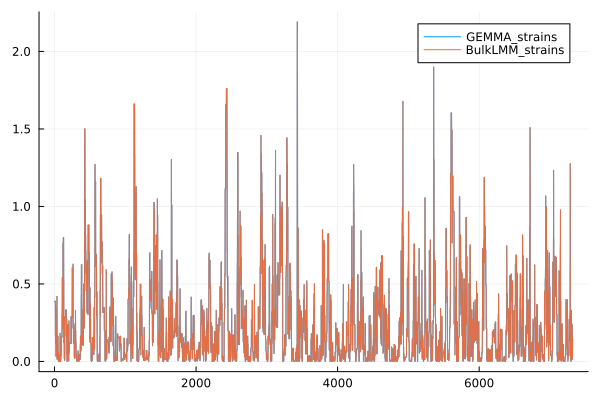

In [163]:
plot(gemma_strains_lod[lookRange], label = "GEMMA_strains");
# plot!(scan_results_strains_alt_hub.lod[lookRange], label = "BulkLMM_strains")
plot!(bulkscan_results_null_strains.L[lookRange, lp_id], label = "BulkLMM_strains")

In [152]:
scan_results_ind.h2_null

1.924162152748015e-15